In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import os
import shutil

### Sinomaly noize

In [2]:
torch.manual_seed(10)

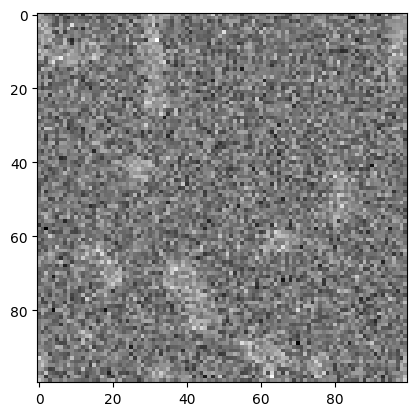

In [99]:
def blur_gaussian(x,sigma):
    x=x.squeeze()
    h,w=x.shape
    p,q=torch.tensor(np.meshgrid(np.fft.fftfreq(w),np.fft.fftfreq(h))).to(x.device)
    X=torch.fft.fft2(x)
    ker=torch.exp(-sigma**2*(p**2+q**2))
    Y = ker * X
    y = torch.fft.ifft2(Y).real
    return y


### Sinomaly noize
def sinomaly_noise_like(img, tau=0.15, σ=15, masque=0, d=1):
    epsilon=torch.randn_like(img,)
    epsilon_1=blur_gaussian(epsilon,σ)
    epsilon_1=(epsilon_1>tau)*d
    if not masque:
        masque=masque+1
    return epsilon+epsilon_1*masque

a=sinomaly_noise_like(torch.zeros(100,100),tau=0.1, σ=15,d=1)
plt.imshow(a,cmap='gray')

# Difusion model

In [4]:
# On réutilise les fichiers existants pour l'architecture de débruiteur et les données
from unet import UNetModel  #
from data_loader import get_training_data #


class SimpleDiffusion:
    def __init__(self, noise_steps=200, device="cuda"):
        self.noise_steps = noise_steps
        self.device = device

        # 1. Définir le "Schedule" (Planning de bruit)
        # On utilise un schedule linéaire standard (comme dans get_beta_schedule("linear"))
        beta_start = 0.0001
        beta_end = 0.02
        self.betas = torch.linspace(beta_start, beta_end, noise_steps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0) # Produit cumulatif

    def noise_images(self, x, t, noise_type='gauss'):
        """
        Ajoute du bruit gaussien pur à l'image x au temps t.
        Formule: x_t = sqrt(alpha_hat)*x_0 + sqrt(1-alpha_hat)*epsilon
        """
        # Assure un bon dimensionnement pour le broadcast
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        if noise_type == 'gauss':
            # Génération du bruit blanc Gaussien (epsilon)
            epsilon = torch.randn_like(x)
        if noise_type == 'sinomaly':
            epsilon = sinomaly_noise_like(x)

        # Image bruitée: x_t = sqrt(alpha_hat)*x_0 + sqrt(1-alpha_hat)*epsilon
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        """Sélectionne des pas de temps aléatoires pour le batch"""
        # Commence à 1 car t=0 n'est pas utilisé dans le processus forward
        return torch.randint(low=1, high=self.noise_steps, size=(n,), device=self.device)

def train_simple_ddpm_full_unet(ARGS):
    print(f"Lancement de l'entraînement sur {ARGS['device']} (Batch size: {ARGS['batch_size']}, Img size: {ARGS['img_size']})...")

    # 1. Préparation des données
    dataloader, _ = get_training_data(ARGS)

    # 2. Initialisation du modèle
    model = UNetModel(
        image_size=ARGS['img_size'],
        in_channels=ARGS['in_channels'],
        model_channels=ARGS['model_channels'],
        out_channels=ARGS['out_channels'],
        num_res_blocks=ARGS['num_res_blocks'],
        attention_resolutions=ARGS['attention_resolutions'],
        dropout=ARGS['dropout'],
        channel_mult=ARGS['channel_mult'],
        num_heads=ARGS['num_heads'],
        num_head_channels=ARGS['num_head_channels'],
    ).to(ARGS['device'])

    print(f"Nombre de paramètres du modèle: {sum(p.numel() for p in model.parameters())}")

    diffusion = SimpleDiffusion(noise_steps=200, device=ARGS['device'])
    optimizer = optim.AdamW(model.parameters(), lr=ARGS['lr'])
    mse = nn.MSELoss()

    # 3. Boucle d'entraînement
    for epoch in range(ARGS['epochs']):
        print(f"\nEpoch {epoch+1}/{ARGS['epochs']}")
        pbar = tqdm(dataloader)
        epoch_loss = []

        for i, images in enumerate(pbar):
            images = images.to(ARGS['device'])

            # A. Sample t et B. Ajout de bruit
            t = diffusion.sample_timesteps(images.shape[0])
            x_t, noise = diffusion.noise_images(images, t)

            # C. Prédiction du bruit
            predicted_noise = model(x_t, t)

            # D. Calcul MSE
            loss = mse(noise, predicted_noise)

            # E. Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            pbar.set_postfix(MSE=loss.item())

        avg_loss = sum(epoch_loss) / len(epoch_loss)
        print(f"Moyenne Loss Epoch {epoch+1}: {avg_loss:.5f}")

        # Sauvegarde
        if (epoch + 1) % 10 == 0:
            save_dir = os.path.join(ARGS['output_path'], 'model', ARGS['json_file_name'])
            os.makedirs(save_dir, exist_ok=True)
            path = os.path.join(save_dir, f"simple_ddpm_ep{epoch+1}.pt")
            torch.save(model.state_dict(), path)
            print(f"Modèle sauvegardé à {path}")

    return model


In [5]:
import torch
import torchvision.transforms.functional as F_trans
import torch.nn.functional as F

def multi_stage_anomaly_detection(model, diffusion, img,
                                  steps_per_stage=250,  # "t" (ex: 250 pour US, 150 pour MRI)
                                  blur_kernel_size=15,  # "n" (Taille du noyau Gaussien)
                                  threshold=0.3,        # "Th" (Seuil d'anomalie)
                                  max_stages=5):        # Max itérations pour éviter le calcul excessif
    """
    Implémente le processus de diffusion multi-étapes pour la détection d'anomalies.

    Args:
        model: Le modèle UNet entraîné (le débruiteur).
        diffusion: L'instance de la classe diffusion (contient alpha_hat, etc.).
        img: L'image d'entrée (Tensor [1, 1, H, W], normalisée entre -1 et 1).
        steps_per_stage: Le pas de temps t pour le bruitage partiel.
        blur_kernel_size: Taille du noyau pour le floutage avant différence.
        threshold: Seuil pour créer le masque binaire.
        max_stages: Nombre maximum d'étapes de raffinement.

    Returns:
        final_mask: Le masque d'anomalie binaire final.
        final_reconstruction: L'image reconstruite (fusionnée).
    """
    device = img.device
    model.eval()

    # Initialisation : x_tilde_0 = x_0 (L'entrée initiale est l'image originale)
    x_tilde = img.clone()

    # Pour le critère d'arrêt (convergence du masque)
    last_mask_sum = 0
    final_mask = None

    print(f"--- Démarrage Multi-stage Diffusion (Max {max_stages} stages) ---")

    for n in range(max_stages):
        # 1. Noising (Bruitage) : x_tilde -> x_noised
        # On ajoute du bruit jusqu'au pas 't' défini par steps_per_stage
        t_tensor = torch.tensor([steps_per_stage], device=device).repeat(x_tilde.shape[0])

        # Note : On bruite l'image courante x_tilde (qui contient les fusions précédentes)
        # x_n,t <- noise(x_tilde_n, t)
        x_noised, _ = diffusion.noise_images(x_tilde, t_tensor)

        # 2. Denoising (Débruitage) : x_noised -> x_hat (Estimation de x_0 sain)
        with torch.no_grad():
            # Le modèle prédit le bruit epsilon
            predicted_noise = model(x_noised, t_tensor)

            # Reconstruction analytique de x_0 à partir de x_t et epsilon prédit
            # x_hat = denoise(x_n,t)
            alpha_hat = diffusion.alpha_hat[t_tensor][:, None, None, None]

            # Formule inverse DDPM : x_0 = (x_t - sqrt(1-alpha_hat)*eps) / sqrt(alpha_hat)
            x_hat = (x_noised - torch.sqrt(1 - alpha_hat) * predicted_noise) / torch.sqrt(alpha_hat)
            x_hat = torch.clamp(x_hat, -1, 1) # On s'assure que l'image reste valide

        # 3. Calcul du Masque d'Anomalie (m_n)
        # m_n = threshold( |blur(x_0) - blur(x_hat)| )

        # Le floutage réduit le bruit haute fréquence pour se concentrer sur les anomalies structurelles
        # Le sigma est dérivé de la taille du noyau (approximation standard OpenCV/PyTorch)
        sigma = 0.3 * ((blur_kernel_size - 1) * 0.5 - 1) + 0.8

        # Attention: On compare toujours à l'image ORIGINALE (img), pas x_tilde
        img_blurred = F_trans.gaussian_blur(img, kernel_size=blur_kernel_size, sigma=sigma)
        x_hat_blurred = F_trans.gaussian_blur(x_hat, kernel_size=blur_kernel_size, sigma=sigma)

        # Carte de différence absolue
        diff_map = torch.abs(img_blurred - x_hat_blurred)

        # Seuillage pour obtenir le masque binaire
        mask_n = (diff_map > threshold).float()

        # 4. Critère d'Arrêt (Termination Criterion)
        # if |sum(m_n) - sum(m_{n-1})| / sum(m_{n-1}) < 0.01 -> STOP
        current_mask_sum = torch.sum(mask_n).item()

        if n > 0 and last_mask_sum > 0:
            relative_change = abs(current_mask_sum - last_mask_sum) / last_mask_sum
            print(f"Stage {n+1}: Changement relatif masque = {relative_change:.4f}")
            if relative_change < 0.01:
                print("-> Convergence atteinte. Arrêt.")
                final_mask = mask_n
                break

        last_mask_sum = current_mask_sum
        final_mask = mask_n # Mise à jour du masque final courant

        # 5. Masked Fusion (Fusion Masquée) - Étape cruciale du papier
        # x_tilde_{n+1} = m_n * x_hat + (1 - m_n) * img
        # On remplace l'image SEULEMENT là où le masque dit "anomalie".
        # Ailleurs, on remet l'image originale PARFAITE pour préserver les détails sains.
        #
        x_tilde = mask_n * x_hat + (1 - mask_n) * img

    return final_mask, x_tilde


# Experimental part

In [6]:
ARGS = {
        "dataset": "lits",
        "output_path": "../output/LiTS",
        "json_file_name": "args_simple_gaussian", # Nom pour les checkpoints
        "img_size": 128,
        "batch_size": 4, # Réduit pour la stabilité
        "num_training_data": 5000,
        "epochs": 1,
        "lr": 1e-4,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "apply_mask": False,

        # Paramètres UNet allégés.
        "in_channels": 1,
        "model_channels": 64,
        "out_channels": 1,
        "num_res_blocks": 2,
        "attention_resolutions": "32,16",
        "dropout": 0.0,
        "channel_mult": "1,2,3,4",
        "num_heads": 2,
        "num_head_channels": 64,
    }

In [7]:
model=train_simple_ddpm_full_unet(ARGS)

Lancement de l'entraînement sur cuda (Batch size: 4, Img size: 128)...
Training on 2378 images
Nombre de paramètres du modèle: 21853249

Epoch 1/1


100%|██████████| 595/595 [01:15<00:00,  7.87it/s, MSE=0.00258]


Moyenne Loss Epoch 1: 0.07567


In [5]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import os

# 1. Définir les chemins de base (similaire à helpers.py)
# Assurez-vous que ce chemin est correct pour votre environnement local
OUTPUT_PATH = "../output/LiTS"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 128 # Taille de l'image après redimensionnement (dans data_loader)

# --- Paramètres de Test factices pour LiTS ---
# Ces paramètres sont nécessaires pour initialiser le data_loader
ARGS = {
    "dataset": "lits",
    "output_path": OUTPUT_PATH,
    "mode": "anomalous", # On charge les images anomales pour l'exemple
    "num_test_img": 1,   # On ne chargera qu'une seule image au hasard
    "img_size": IMG_SIZE,
    "Version": "old"
}

def load_random_lits_image():
    """Charge une image aléatoire du jeu de données de test LiTS."""

    # Étape A: Charger les données brutes (listes d'arrays NumPy)
    # Le chemin pointe vers le jeu de données anomales LiTS
    try:
        with open(f"{OUTPUT_PATH}/test_anomalous_abdomen_dataset.pkl", "rb") as f:
            data = pickle.load(f)
        print(f"Dataset chargé. Nombre total d'images: {len(data)}")
    except FileNotFoundError:
        print(f"Erreur : Le fichier de données LiTS n'a pas été trouvé à {OUTPUT_PATH}/test_anomalous_abdomen_dataset.pkl.")
        return

    # Étape B: Sélectionner un index aléatoire
    random_index = random.randint(0, len(data) - 1)

    # Étape C: Créer une DataLoader juste pour cette image (ou utiliser l'array NumPy direct)
    # Dans ce cas, on utilise l'array NumPy directement
    image_array = data[random_index]
    print(image_array.shape)
    # Étape D: Simuler les transformations de data_loader.py (Redimensionnement, RescaleToMinusOneToOne)
    # Il est plus simple d'utiliser directement la fonction get_test_data_ (même si elle nécessite un refactoring)

    # --- Si vous utilisez le data_loader.py fourni ---

    # Pour utiliser les transformations exactes du data_loader, on va importer et appeler sa logique.
    from data_loader import UltrasoundDataset, DataLoader # On utilise UltrasoundDataset car il est utilisé pour LiTS

    # 1. Créer le dataset (applique les transformations)
    dataset = UltrasoundDataset([image_array], IMG_SIZE, augment=False)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # 2. Extraire le tenseur transformé
    transformed_image = next(iter(dataloader)).to(DEVICE)
    """
    # 3. Afficher l'image (dénormalisée pour la visualisation)
    # L'image est dans la plage [-1, 1], nous la ramenons à [0, 1] pour matplotlib
    image_to_plot = (transformed_image.cpu().squeeze().numpy() + 1) / 2

    plt.figure(figsize=(6, 6))
    plt.imshow(image_to_plot, cmap='gray')
    plt.title(f"Image LiTS anomale (index {random_index}) - {IMG_SIZE}x{IMG_SIZE}")
    plt.axis('off')
    plt.show()"""
    return transformed_image

# Exécuter la fonction
image=load_random_lits_image()

Dataset chargé. Nombre total d'images: 1000
(512, 512)


In [15]:
def afficher_une_image(img,title=""):
    image_to_plot = (img.cpu().squeeze().detach().numpy() + 1) / 2
    n,m=image_to_plot.shape
    plt.figure(figsize=(6, 6))
    plt.imshow(image_to_plot, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [16]:
model.eval()
t = torch.tensor([10]).to(image.device)
a=model(image,t)
a.shape

torch.Size([1, 1, 128, 128])

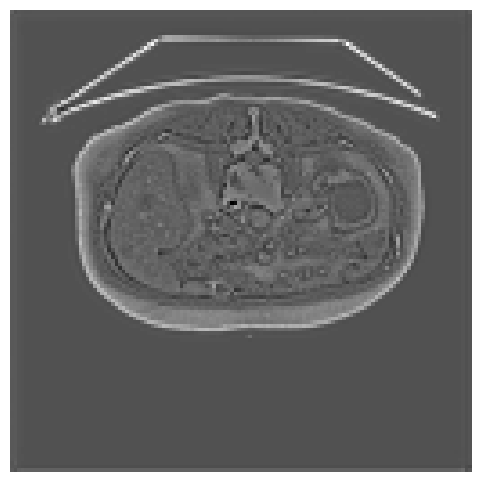

In [17]:
afficher_une_image(a)

In [11]:
ε=sinomaly_noise_like(torch.tensor(np.zeros((128,128))),0.16)

C:\Users\danku\AppData\Local\Temp\ipykernel_34072\1972013155.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  p,q=torch.tensor(np.meshgrid(np.fft.fftfreq(w),np.fft.fftfreq(h))).to(x.device)


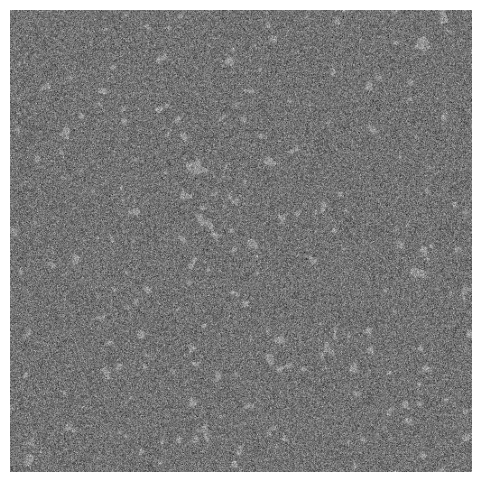

In [12]:
afficher_une_image(ε)

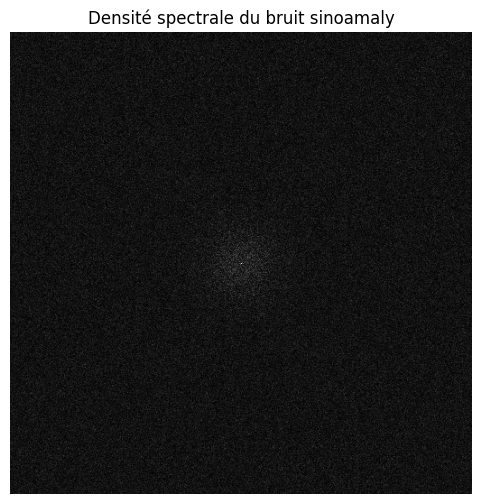

In [13]:
afficher_une_image(torch.fft.fftshift(torch.abs(torch.fft.fft2(ε))),title="Densité spectrale du bruit sinoamaly")

In [14]:
afficher_une_image(b)

NameError: name 'b' is not defined

In [6]:
torch.min(b)

NameError: name 'b' is not defined